In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split


In [2]:
from vehicle_detection.sliding_window import single_img_features
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #image = np.int8(mpimg.imread(file)*255) + 128
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)

        #print("shape:", image.shape)
        current_features = single_img_features(image, cspace, spatial_size=(32,32),hist_bins=32,
                                              orient=orient, pix_per_cell=pix_per_cell,
                                              cell_per_block=cell_per_block,
                                              hog_channel=hog_channel, hist_feat=hist_feat)
        # Append the new feature vector to the features list
        #print("l:", len(current_features))
        features.append(current_features)
    # Return list of feature vectors
    print("Extracted {} features.".format(len(features)))
    return features



In [3]:
# Divide up into cars and notcars
images = glob.glob('*.jpeg')
cars = glob.glob('../vehicles/**/*.png')
notcars = glob.glob('../non-vehicles/**/*.png')

from sklearn.utils import shuffle
cars = shuffle(cars)
notcars = shuffle(notcars)

print("Found {} cars and {} non-cars.".format(len(cars), len(notcars)))

Found 8792 cars and 8968 non-cars.


In [4]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
#sample_size = 500
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]

In [5]:
cs = cars[0:3]
print(cs)
f = extract_features(cs, 'YUV', 9, 8, 2, 0)
#print(mpimg.imread(cs[0])*255)

['../vehicles/KITTI_extracted/1637.png', '../vehicles/GTI_Far/image0067.png', '../vehicles/GTI_Far/image0592.png']
Extracted 3 features.


(64, 64, 3) 255
102.852213542 62.1403543152 255 21


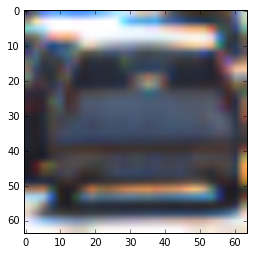

In [6]:
img = np.int8(mpimg.imread(cs[0])*255) + 128
img = cv2.cvtColor(cv2.imread(cs[0]), cv2.COLOR_BGR2RGB)
print(img.shape, np.max(img))
print(np.mean(img), np.std(img), np.max(img), np.min(img))
plt.imshow(img)
plt.show()

In [7]:

def train_and_evaluate_svm(colorspace = 'RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_feat=True):
    t=time.time()
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_feat=hist_feat)
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                            pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_feat=hist_feat)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block',
        'in color space', colorspace,'and hog channel',hog_channel)
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print("="*30)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print("="*30)
    # Check the prediction time for a single sample
    if False:
        t=time.time()
        n_predict = 15
        print('My SVC predicts:     ', svc.predict(X_test[0:n_predict]))
        print('For these',n_predict, 'labels: ', y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    del car_features
    del notcar_features
    del X
    del scaled_X
    return svc, X_scaler
#train_and_evaluate_svm()

In [10]:
# quick and good:
# cell_per_block: 3, colorspace: HSV, hog_channel: ALL, orient: 6, pix_per_cell: 12, 
#p = {'cell_per_block': 2, 'colorspace': 'HSV', 'orient': 16, 'pix_per_cell': 8, 'hog_channel': 'ALL'}
#my_svm, my_scaler = train_and_evaluate_svm('HSV', 6, 12, 3, 'ALL')
#p = {'pix_per_cell': 8, 'hog_channel': 'ALL', 'orient': 8, 'cell_per_block': 3, 'colorspace': 'HSV'}
p =  {'pix_per_cell': 10, 'colorspace': 'YUV', 'cell_per_block': 2, 'orient': 9, 'hog_channel': 0, 'hist_feat': False}
p =  {'pix_per_cell': 8, 'colorspace': 'YCrCb', 'cell_per_block': 2, 'orient': 9, 'hog_channel': 'ALL', 'hist_feat': False}
my_svm, my_scaler = train_and_evaluate_svm(colorspace=p['colorspace'], 
                                           orient=p['orient'], 
                                           pix_per_cell=p['pix_per_cell'], 
                                           cell_per_block=p['cell_per_block'], 
                                           hog_channel=p['hog_channel'],
                                           hist_feat=p['hist_feat'])


Extracted 8792 features.
Extracted 8968 features.
113.41 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block in color space YCrCb and hog channel ALL
Feature vector length: 5292
10.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


In [11]:
import pickle

with open('hog_svm.p', 'wb') as f:
    pickle.dump((p, my_svm, my_scaler), f)

In [ ]:
# My gridsearch

class Choose:            
    def __init__(self, what):
        self.what = what
    def sample(self):
        idx = np.random.randint(0, len(self.what))
        return self.what[idx]

def sample_all(params):
    all_params = {}
    for key in params.keys():
        all_params[key] = params[key].sample()
    return all_params
    
    
def search(n, function, params):
    for i in range(n):
        p = sample_all(params)
        print("p = ", p)
        function(colorspace = p['colorspace'], orient=p['orient'], 
                 pix_per_cell=p['pix_per_cell'], 
                 cell_per_block=p['cell_per_block'], 
                 hog_channel=p['hog_channel'])
        



In [ ]:
params = {
    "colorspace": Choose(['RGB', 'HSV', 'HLS', 'YUV', 'YCrCb']),
    "orient": Choose([8, 9, 10, 12]),
    "pix_per_cell": Choose([6,8,10]),
    "cell_per_block": Choose([2,3,4]),
    "hog_channel": Choose([0, 1, 2, 'ALL']),
    "hist_feat": Choose([True, False]),
}

np.random.seed(42)

search(100, train_and_evaluate_svm, params)